In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
import gc
#from torch import cuda
import acorn.core
print(acorn.core.__file__)

import numpy as np
import pandas as pd
import scipy.sparse as sps
import yaml
from itertools import chain, product, combinations
import torch

from time import time as tt
from tqdm import tqdm
import wandb
from acorn.stages.data_reading import AthenaReader
from acorn.core.infer_stage import infer
from acorn.core.eval_stage import evaluate

from acorn.stages.data_reading.models.trackml_utils import *

from acorn.stages.data_reading.data_reading_stage import EventReader
from acorn.stages.data_reading.models.trackml_reader import TrackMLReader

from acorn.stages.graph_construction.models.metric_learning import MetricLearning
from acorn.stages.edge_classifier.models.filter import Filter
from acorn.stages.edge_classifier import InteractionGNN
from acorn.stages.edge_classifier.edge_classifier_stage import EdgeClassifierStage, GraphDataset

from acorn.stages.graph_construction.utils import handle_weighting
from acorn.stages.graph_construction.models.utils import graph_intersection, build_edges
from acorn.stages.graph_construction.utils import *
from acorn.stages.graph_construction.models.py_module_map import PyModuleMap
from acorn.stages.graph_construction.graph_construction_stage import GraphConstructionStage

from acorn.utils import handle_hard_node_cuts

from acorn.stages.track_building import utils 
from torch_geometric.utils import to_scipy_sparse_matrix
from torch_geometric.data import Batch

from acorn.utils import handle_hard_cuts

#run = wandb.init(project=model_gnn.hparams["project"], entity='gnnproject')
torch.set_float32_matmul_precision('highest')

/global/u2/a/alazar/acorn/acorn/core/__init__.py


/global/homes/a/alazar/.conda/envs/acorn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
confidr = "../../examples/Example_1/data_reader.yaml"
configMm = "../../examples/Example_1/module_map_infer.yaml"
configGnn = "../../examples/Example_1/gnn_infer.yaml"
configGnn_eval = "../../examples/Example_1/gnn_eval.yaml"
configTbi = "../../examples/Example_1/track_building_infer.yaml"
configTbe = "../../examples/Example_1/track_building_eval.yaml"

In [3]:
gnn_dir = "/pscratch/sd/a/alazar/cf/Example_1/gnn/"
gnn_val = os.path.join(gnn_dir, "testset")
all_events = [event for event in os.listdir(gnn_val) if event.endswith(".pyg")]
all_events = sorted(all_events)

event0 = torch.load(os.path.join(gnn_val, all_events[1]))
event1 = torch.load(os.path.join(gnn_val, all_events[9]))

In [4]:
print(event0.event_id, event1.event_id)
print(event0.edge_index.shape, event1.edge_index.shape)
print(event0.scores.sum())
print(event0)

['000000114'] ['000000192']
torch.Size([2, 35692]) torch.Size([2, 36166])
tensor(14324.0840)
DataBatch(x=[305260], edge_index=[2, 35692], y=[35692], norm_y_1=[305260], eta=[305260], hit_id=[305260], eta_angle_2=[305260], cluster_x_2=[305260], phi_angle_1=[305260], phi_angle_2=[305260], eta_angle_1=[305260], module_id=[305260], z=[305260], norm_z_2=[305260], norm_y_2=[305260], norm_z_1=[305260], norm_x_1=[305260], cluster_z_2=[305260], cluster_x_1=[305260], cluster_y_2=[305260], phi=[305260], region=[305260], cluster_y_1=[305260], cluster_z_1=[305260], norm_x_2=[305260], r=[305260], track_edges=[2, 14912], nhits=[14912], primary=[14912], radius=[14912], particle_id=[14912], pdgId=[14912], pt=[14912], config=[2], event_id=[1], truth_map=[14912], weights=[35692], batch=[305260], ptr=[2], scores=[35692])


In [5]:
# tracking_dir = "/pscratch/sd/a/alazar/cf/Example_1/connected_components"
# tracking_val = os.path.join(tracking_dir, "valset")
# all_events = os.listdir(tracking_val)
# event0 = torch.load(os.path.join(tracking_val, all_events[0]))
# event1 = torch.load(os.path.join(tracking_val, all_events[1]))

In [6]:
event0.event_id, event1.event_id

(['000000114'], ['000000192'])

In [7]:
print((event0.scores).sum(), (event1.scores).sum())
print((event0.scores > 0.8).sum(), (event1.scores > 0.8).sum())

tensor(14324.0840) tensor(14573.6367)
tensor(13480) tensor(13867)


In [8]:
#infer(configMm)
#infer(configGnn,checkpoint=config_gnn['stage_dir']+'artifacts/best-4l0jlwuh-val_loss=0.085163-epoch=77.ckpt')
#infer(configTbi)


100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


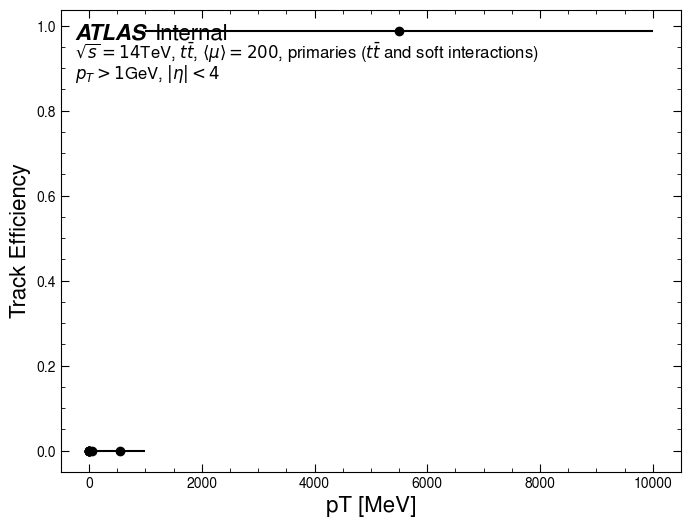

In [9]:
evaluate(configTbe,None,dataset="testset")

In [10]:
with open("../../examples/Example_1/module_map_infer.yaml", "r") as f:
    config_mm = yaml.load(f, Loader=yaml.FullLoader)
model_mm = PyModuleMap(config_mm)
model_mm.setup(stage="predict")
model_mm.load_module_map()
model_mm.load_data("/pscratch/sd/a/alazar/cf/Example_1/feature_store/")

Loaded 0 training events, 10 validation events and 10 testing events
Loaded 0 training events, 10 validation events and 10 testing events


In [11]:
with open("../../examples/Example_1/gnn_train.yaml", "r") as f:
    config_gnn = yaml.load(f, Loader=yaml.FullLoader)
model_gnn = InteractionGNN(config_gnn)
model_gnn.setup('fit')
model_gnn = InteractionGNN.load_from_checkpoint(config_gnn['stage_dir']+'artifacts/last--v1.ckpt', hparams=config_gnn)
model_gnn.setup('predict')
dataloaders_gnn = model_gnn.predict_dataloader()

config_tbe = yaml.safe_load(open("../../examples/Example_1/track_building_eval.yaml", "r"))
print(config_gnn['stage_dir']+'artifacts')

cpu
cuda:0 cuda:0 cuda:0


/global/u2/a/alazar/acorn/acorn/utils/loading_utils.py:79: UserWarning: OPTIONAL feature [particle_id] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/a/alazar/acorn/acorn/utils/loading_utils.py:79: UserWarning: OPTIONAL feature [nhits] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/a/alazar/acorn/acorn/utils/loading_utils.py:79: UserWarning: OPTIONAL feature [primary] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/a/alazar/acorn/acorn/utils/loading_utils.py:79: UserWarning: OPTIONAL feature [pdgId] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/a/alazar/acorn/acorn/utils/loading_utils.py:79: UserWarning: OPTIONAL feature [ghost] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/global/u2/a/alazar/acorn/acorn/utils/loading_utils.py:79: UserWarning: OPTIONAL f

cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
Defining figures of merit


/global/u2/a/alazar/acorn/acorn/stages/edge_classifier/edge_classifier_stage.py:98: UserWarning: Failed to define figures of merit, due to logger unavailable
  warnings.warn(


cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
Defining figures of merit
/pscratch/sd/a/alazar/cf/Example_1/gnn/artifacts


In [12]:
def make_result_summary(
    n_reconstructed_particles,
    n_particles,
    n_matched_tracks,
    n_tracks,
    n_dup_reconstructed_particles,
    eff,
    fake_rate,
    dup_rate,
):
    summary = f"Number of reconstructed particles: {n_reconstructed_particles}\n"
    summary += f"Number of particles: {n_particles}\n"
    summary += f"Number of matched tracks: {n_matched_tracks}\n"
    summary += f"Number of tracks: {n_tracks}\n"
    summary += (
        "Number of duplicate reconstructed particles:"
        f" {n_dup_reconstructed_particles}\n"
    )
    summary += f"Efficiency: {eff:.3f}\n"
    summary += f"Fake rate: {fake_rate:.3f}\n"
    summary += f"Duplication rate: {dup_rate:.3f}\n"

    return summary


def tracking_efficiency(dataset, config): #plot_config,
    """
    Plot the track efficiency vs. pT of the edge.
    """
    all_y_truth, all_pt = [], []
    #dataset = getattr(self, config["dataset"])

    evaluated_events = []
    for event in tqdm(dataset):
        evaluated_events.append(
            utils.evaluate_labelled_graph(
                event,
                matching_fraction=config["matching_fraction"],
                matching_style=config["matching_style"],
                sel_conf=config["target_tracks"],
                min_track_length=config["min_track_length"],
            )
        )

    evaluated_events = pd.concat(evaluated_events)
    #print("Debug: ", evaluated_events)
    particles = evaluated_events[evaluated_events["is_reconstructable"]]
    reconstructed_particles = particles[
        particles["is_reconstructed"] & particles["is_matchable"]
    ]
    tracks = evaluated_events[evaluated_events["is_matchable"]]
    matched_tracks = tracks[tracks["is_matched"]]

    n_particles = len(particles.drop_duplicates(subset=["event_id", "particle_id"]))
    n_reconstructed_particles = len(
        reconstructed_particles.drop_duplicates(subset=["event_id", "particle_id"])
    )

    n_tracks = len(tracks.drop_duplicates(subset=["event_id", "track_id"]))
    n_matched_tracks = len(
        matched_tracks.drop_duplicates(subset=["event_id", "track_id"])
    )

    n_dup_reconstructed_particles = (
        len(reconstructed_particles) - n_reconstructed_particles
    )

    eff = n_reconstructed_particles / n_particles
    fake_rate = 1 - (n_matched_tracks / n_tracks)
    dup_rate = n_dup_reconstructed_particles / n_reconstructed_particles

    result_summary = make_result_summary(
        n_reconstructed_particles,
        n_particles,
        n_matched_tracks,
        n_tracks,
        n_dup_reconstructed_particles,
        eff,
        fake_rate,
        dup_rate,
    )

    print(f"Number of reconstructed particles: {n_reconstructed_particles}")
    print(f"Number of particles: {n_particles}")
    print(f"Number of matched tracks: {n_matched_tracks}")
    print(f"Number of tracks: {n_tracks}")
    print(f"Number of duplicate reconstructed particles: {n_dup_reconstructed_particles}")   
    print(f"Efficiency: {eff:.3f}")
    print(f"Fake rate: {fake_rate:.3f}")
    print(f"Duplication rate: {dup_rate:.3f}")

    #self.log.info("Result Summary :\n\n" + result_summary)

    # res_fname = os.path.join(
    #     self.hparams["stage_dir"],
    #     f"results_summary_{self.hparams['matching_style']}.txt",
    # )

    # with open(res_fname, "w") as f:
    #     f.write(result_summary)

    # First get the list of particles without duplicates
    grouped_reco_particles = particles.groupby("particle_id")[
        "is_reconstructed"
    ].any()
    # particles["is_reconstructed"] = particles["particle_id"].isin(grouped_reco_particles[grouped_reco_particles].index.values)
    particles.loc[
        particles["particle_id"].isin(
            grouped_reco_particles[grouped_reco_particles].index.values
        ),
        "is_reconstructed",
    ] = True
    particles = particles.drop_duplicates(subset=["particle_id"])

    # Plot the results across pT and eta (if provided in conf file)
    #os.makedirs(self.hparams["stage_dir"], exist_ok=True)

    # for var, varconf in plot_config["variables"].items():
    #     utils.plot_eff(
    #         particles,
    #         var,
    #         varconf,
    #         save_path=os.path.join(
    #             self.hparams["stage_dir"],
    #             f"track_reconstruction_eff_vs_{var}_{self.hparams['matching_style']}.png",
    #         ),
    #     )

In [13]:
with open(configTbi, 'r') as f:
    config_tbi = yaml.full_load(f)

In [14]:
def scale_features(event, config):
    """
    Handle feature scaling for the event
    """

    if (
        config is not None
        and "node_scales" in config.keys()
        and "node_features" in config.keys()
    ):
        assert isinstance(
            config["node_scales"], list
        ), "Feature scaling must be a list of ints or floats"
        for i, feature in enumerate(config["node_features"]):
            assert feature in get_pyg_data_keys(
                event
            ), f"Feature {feature} not found in event"
            event[feature] = event[feature] / config["node_scales"][i]

    return event

def add_edge_features(event, config):
    if "edge_features" in config.keys():
        assert isinstance(
            config["edge_features"], list
        ), "Edge features must be a list of strings"
        handle_edge_features(event, config["edge_features"])
    return event

In [ ]:
#%reload_ext autoreload
from torch import cuda
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
cur_allocated_mem = {}
cur_cached_mem = {}
max_allocated_mem = {}
max_cached_mem = {}
i=0

model_mm = model_mm.to(device)
model_gnn = model_gnn.to(device)

graphs = []
for batch_idx, (graph, _, truth) in enumerate(model_mm.testset):
#for batch_idx, batch in enumerate(model_gnn.valset):
    print(graph.event_id)
    if graph.event_id != '000000114': continue
    batch, mm_time = model_mm.build_graph(graph.to(device), truth) 
    # want bypass saving to disk
    # Initiate a graph dataset instance from the batch
    # Why is event.edge_index not in the GPU
    handle_hard_cuts(batch, config_gnn["hard_cuts"])
    print(batch.edge_index.device)
    batch = scale_features(batch, config_gnn)
    print(batch.device)
    if config_gnn.get("edge_features") is not None:
        batch = add_edge_features(
            batch
        )  # scaling must be done before adding features
    # batch = model_gnn.valset.preprocess_event(batch)
    with torch.no_grad():
        batch.scores = torch.sigmoid(model_gnn(batch.to(device)))
        #gnn = model_gnn(batch)
        #batch = gnn['batch']

    #batch.scores = torch.sigmoid(gnn['output'])

    edge_mask = batch.scores > config_tbi['score_cut']

    # Get number of nodes
    if hasattr(batch, "num_nodes"):
        num_nodes = batch.num_nodes
    elif hasattr(batch, "x"):
        num_nodes = batch.x.size(0)
    elif hasattr(batch, "x_x"):
        num_nodes = batch.x_x.size(0)
    else:
        num_nodes = batch.edge_index.max().item() + 1
    # Convert to sparse scipy array
    sparse_edges = to_scipy_sparse_matrix(
        batch.edge_index[:, edge_mask], num_nodes=num_nodes
    )
    # Run connected components
    _, candidate_labels = sps.csgraph.connected_components(
        sparse_edges, directed=False, return_labels=True
    )
    batch.labels = torch.from_numpy(candidate_labels).long()

    # tbe_dataset.preprocess_event(batch)

    graphs.append(batch.to('cpu'))
    #del batch #, gnn 
    gc.collect()
    torch.cuda.empty_cache()

tracking_efficiency(graphs, config_tbe)

In [15]:
model_gnn.valset.preprocess = True
for event in model_gnn.valset:
    if event.event_id != '000000114': continue
    event = event.to('cuda')
    # print(event.event_id, event.edge_index.shape, (event.truth_map > -1).sum())
    event = model_gnn.valset.preprocess_event(event)
    break
    

cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
cpu
cuda:0 cuda:0 cuda:0
cuda:0
cuda:0 cuda:0 cuda:0


In [16]:
# sorting edges according to first hit_id and then 2 hit_id

def sorted_edge_index(edge_index, tensor):
    dst = edge_index[1]
    sorted_indices = torch.argsort(dst)
    edge_index = edge_index[:, sorted_indices]
    tensor = tensor[sorted_indices]
    outter_sorted_indices = torch.argsort(edge_index[0])
    edge_index = edge_index[:, outter_sorted_indices]
    tensor = tensor[outter_sorted_indices]
    return edge_index, tensor


In [17]:
event_sorted_edge_index, event_scores = sorted_edge_index(event0.edge_index, event0.scores)

In [18]:
batch_sorted_edge_index, batch_scores = sorted_edge_index(batch.edge_index, batch.scores)

NameError: name 'batch' is not defined

In [ ]:
event_scores, batch_scores

In [ ]:
# Test if event and batch scores are CLOSE
torch.isclose(event_scores, batch_scores, atol=1e-2).sum()

In [ ]:
event_scores.shape

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.histplot(event_scores.cpu().numpy(), bins=100, log_scale=(False, True))
#sns.histplot(batch.scores.cpu().numpy(), ax=ax, bins=100, log_scale=(False, True), alpha=0.5)


In [ ]:
event0.to('cuda').scores.sum()

In [ ]:
scores.sum()

In [ ]:
event_sorted_edge_index = sorted_edge_index(event0.edge_index.cpu())
batch_sorted_edge_index = sorted_edge_index(batch.edge_index.cpu())
(event_sorted_edge_index - batch_sorted_edge_index).abs().sum()

In [ ]:
event0.weights.sum(), batch.weights.sum()

In [ ]:
batch_sorted_edge_index

In [ ]:
difference = (event_sorted_edge_index - batch_sorted_edge_index).abs()
difference = difference[0] + difference[1]
mask = difference > 0



In [ ]:
event_sorted_edge_index[:, mask]

In [ ]:
print(batch_sorted_edge_index[:, mask])

In [ ]:
event0.scores.max(), event0.scores.sum()

In [ ]:
batch.scores.max(), batch.scores.sum()

In [ ]:
batch, event0.r

In [ ]:
from numba import njit

@njit
def concatenate_unicode_strings(a, b):
    return a + b

string1 = "Hello"
string2 = "World"
result = concatenate_unicode_strings(string1, string2)
print(result)

In [ ]:
    import dask_cudf
    import cudf
    s = cudf.Series(['detamax_'])
    s= s.str.cat(['12'])
    print(s[0])

In [ ]:
#%load_ext cudf.pandas
import pandas as pd
import polars as pl
import numpy as np
import cudf
myids=np.random.choice(np.arange(10000000), size=10000000, replace=False)
df1 = pd.DataFrame(myids, columns=['A'])
df1['B'] = np.random.randint(0,1000,(10000000))
df2 = pd.DataFrame(np.random.permutation(myids), columns=['A2'])
df2['B2'] = np.random.randint(0,1000,(10000000))

ddf1 = cudf.from_pandas(df1)
ddf2 = cudf.from_pandas(df2)
ddf1.set_index("A", inplace=True)
ddf2.set_index("A2", inplace=True)

pdf1 = pl.from_pandas(df1)
pdf2 = pl.from_pandas(df2)

In [ ]:
%%timeit
    x = ddf1.merge(ddf2, how='inner', left_on='A', right_on='A2')

In [ ]:
%%timeit
    x = ddf1.join(ddf2, how='left')

In [ ]:
%%timeit
    x = df1.merge(df2, how='left', left_on='A', right_on='A2')   
#1 loop, best of 3: 664 ms per loop


In [ ]:
%%timeit  
    x = df1.set_index('A').join(df2.set_index('A2'), how='left') 
#1 loop, best of 3: 354 ms per loop

In [ ]:
%%time 
    df1.set_index('A', inplace=True)
    df2.set_index('A2', inplace=True)
#Wall time: 16 ms

In [ ]:
%%timeit
    x = df1.join(df2, how='left')  
#10 loops, best of 3: 80.4 ms per loop

In [ ]:
%%timeit
    x = pdf1.join(pdf2, how='left',left_on="A", right_on="A2")  
#10 loops, best of 3: 80.4 ms per loop

In [ ]:
ddf1.dtypes

In [ ]:
import cudf

df = cudf.DataFrame({
    'a': [1,2,3],
    'b': [4,5,6]
})

def f(row):
    x = row['a']
    y = row['b']

    return x + y - 1

result = df.apply(f, axis=1)
print(result)